### 2.3 Lab Assignment
Monica Alicea, Kelton Berry, Andrew Caietti, Asha Silva

4/2/21

DATA 330 

Professor Davis

# Introduction


## Outliers

An outlier is defined as any observation that lies outside the general distribution pattern of the population as well as outside a majority of other values. These points are considered to be an abnormal distance from the other data points (Glen). An outlier can be calculated as any point that is greater than the third quartile + 1.5 times the interquartile range (IQR) or less than the first quartile - 1.5 times the interquartile range. There are many factors that cause outliers. These reasons include - but are not limited to - human, instrumental, data processing and sampling errors. Outliers can also occur naturally and are considered novelties in data (Santoyo 2017). Outliers are important because of their effects on statistical analysis, such as linear regressions. Outliers may violate the assumptions required to perform parametric analyses. Outliers also skew statistical tests by increasing data variation. This can lead to biased population estimators. However, it is important to note that sometimes the outliers of a dataset may be the focus when we want to study abnormal occurrences in the population (Yang 2016).

## Peirce's Criterion

Peirce's criterion is a statistical method for removing outliers from data sets (Wikipedia 2020). After being lost to the scientific community for over 150 years, Peirce's criterion has made a resurgence because of its unique but effective methodology (Ross 2003). Peirce's method is unique because it does not depend on the observational data, only on qualities of the observational data (Wikipedia 2020). The number of observation pairs, number of outliers to be removed (starting at 1, and increasing incrementally until number of outliers to be removed is bigger than number of outliers actually identified in the dataset), and number of regression parameters are using to calculate a threshold value (Ross 2003). To re-associate this threshold with the data, it is multiplied by the mean-squared error of the dataset. The squared error of every observation is then compared to this new, data-specific threshold, where values bigger than the treshold are considered outliers (Wikipedia 2020). Overall, Peirce's criterion provides a successful and repeatable method for detecting and removing outliers, which improves the fit between the observation points and a curve (Wikipedia 2020). 

## Chauvenet's Criterion
Another method of identifying outliers is Chauvenet's criterion. This method works similarly to other outlier criterion in that it identifies an acceptable region around the data where data can be reasonably assumed to not be outliers, then scrutinizes datum that fall outside of this region. This is done mathematically by identifying the sample mean and standard deviation as well as the standard deviation of all outliers. 

Chauvenet specifically incorporates the assumption of a normal distribution telling us that 95% of our data will be within 2 standard deviations of the sample mean. So any observations outside of this range are scrutinized and, as a rule of thumb, we know that no more than [5% of observations should be removed](https://www.statisticshowto.com/chauvenets-criterion/) (Stephanie, N/A; Brightwell et. al, 2017).

If a data point under scrutiny is identified, through the calculation of Chauvenet's criterion, as having a probability of existing less than 0.5 (0 < p < 1) at its given point based on the distribution of the data, then the data point is removed.

This method makes the critical assumption of a normal distribution of data. If this is not the case, the data must be standardized, or else this method cannot be used. One critique of Chauvenet's when compared to Peirce's criterion is the assumptions for [rejecting data being probabilistic and Chauvenet's inapplicability to multiple data points in a given iteration when compared to Peirce](https://classes.engineering.wustl.edu/2009/fall/che473/handouts/OutlierRejection.pdf)(Ross, 2003). Peirce's method is identified as more rigorous in application and thus admirable when compared to Chauvenet. Given Peirce's criterions ability to be more easily applied with less computational burden makes it a more appealing method for outlier identification when compared to Chauvenet's criterion. 


## FLUXNET

[FLUXNET](https://fluxnet.org/about/) is a network of measuring sites found throughout the world that capture and measure fluxes of trace gases between the land and atmosphere. The network, hosted by the Lawrence Berkeley National Laboratory, comprises over eight hundred flux measuring sites found throughout North and South America, Africa, Asia, and Europe. Data from these sites are collected and maintained by local teams and regional networks. 

Released a few years ago, the [FLEXNET2015](https://fluxnet.org/data/fluxnet2015-dataset/) database captures data from 212 flux measuring sites. Fluxes are measured via the eddy covariance method which computes ["the covariance between the vertical velocity and target scalar mixing ratios at each individual node"](https://fluxnet.org/data/). The database contains the eddy covariance calculated fluxes of both scalars (such as C02 and water vapor) and energy (such as latent heat) from the biosphere and atmosphere. The FLUXNET2015 database consists of these calculated fluxes on a half-hour basis. The link to the main FLEXNET webpage and the FLEXNET2015 database can be found by navigating to [here](https://fluxnet.org/).

# Methods
Below is the two functions used in the methodology. The first function peirce_dev, calculates peirces threshold. The second function get_outliers, reassociates pierces threshold with the data and removes outliers from the dataset accordingly. 

#### Peirce's Criterion Function

In [ ]:
peirce_dev <- function(N, n, m) {
    # N :: total number of observations
    # n :: number of outliers to be removed
    # m :: number of model unknowns (e.g., regression parameters)
    #
    # Check number of observations:
    if (N > 1) {
       # Calculate Q (Nth root of Gould's equation B):
       Q = (n^(n/N) * (N-n)^((N-n)/N))/N
       #
       # Initialize R values:
       Rnew = 1.0
       Rold = 0.0  # <- Necessary to prompt while loop
       #
       while (abs(Rnew-Rold) > (N*2.0e-16)) {
           # Calculate Lamda (1/(N-n)th root of Gould's equation A'):
           ldiv = Rnew^n
           if (ldiv == 0) {
              ldiv = 1.0e-6
           }
           Lamda = ((Q^N)/(ldiv))^(1.0/(N-n))
           #
           # Calculate x-squared (Gould's equation C):
           x2 = 1.0 + (N-m-n)/n * (1.0-Lamda^2.0)
           #
           # If x2 goes negative, set equal to zero:
           if (x2 < 0) {
              x2 = 0
              Rold = Rnew
           } else {
              #
              # Use x-squared to update R (Gould's equation D):
              # NOTE: error function (erfc) is replaced with pnorm (Rbasic):
              # source: 
              # http://stat.ethz.ch/R-manual/R-patched/library/stats/html/Normal.html
              Rold = Rnew
              Rnew = exp((x2-1)/2.0)*(2*pnorm(sqrt(x2)/sqrt(2)*sqrt(2), lower=FALSE))
           }
       }
    } else {
       x2 = 0
    }
    x2
}

#### Get Outliers function

In [ ]:
get_outliers <- function(fit, obs, np, mse){
    # Calculate the square errors:
    sq_errors <- (obs - fit)^2.0
    #print(sq_errors)

   # Set Peirce values:
    peirce_cap_n <- length(obs)
    peirce_lc_n <- 1
    peirce_m <- np

    # Calculate tolerance
    peirce_x2 <- peirce_dev(peirce_cap_n, peirce_lc_n, peirce_m)
    peirce_delta2 <- mse*peirce_x2
    #print(peirce_delta2)
    # Find if/where exceedance occurs:
    outliers_index <- which(sq_errors > peirce_delta2)
    outliers_found <- length(outliers_index)
    #print(outliers_index)
    # Run check again if no outliers are found in first attempt:
    if (outliers_found == 0){
        peirce_lc_n <- 2
        peirce_x2 <- peirce_dev(peirce_cap_n, peirce_lc_n, peirce_m)
        peirce_delta2 <- mse*peirce_x2
        outliers_index <- which(sq_errors > peirce_delta2)
        outliers_found <- length(outliers_index)

        # Reset n
        peirce_lc_n <- 1}

    # Increment n until it is greater than number of outliers found:
    while (peirce_lc_n <= outliers_found){
        peirce_lc_n <- peirce_lc_n + 1

        # Check that n < N:
        if (peirce_lc_n >= peirce_cap_n){
            peirce_lc_n <- outliers_found + 1.0}
        else{
            peirce_x2 <- peirce_dev(peirce_cap_n, peirce_lc_n, peirce_m)
            peirce_delta2 <- mse*peirce_x2
            outliers_index <- which(sq_errors > peirce_delta2)
            outliers_found <- length(outliers_index)}}

   # logging.debug("Found %d outliers", outliers_found)
    return(outliers_index)
}

# Results
Below we are identifying the outliers through peirce's criterion. Data points deemed outliers are signified in green in the plot below. 

Total Number of Outliers in the Dataset:  72

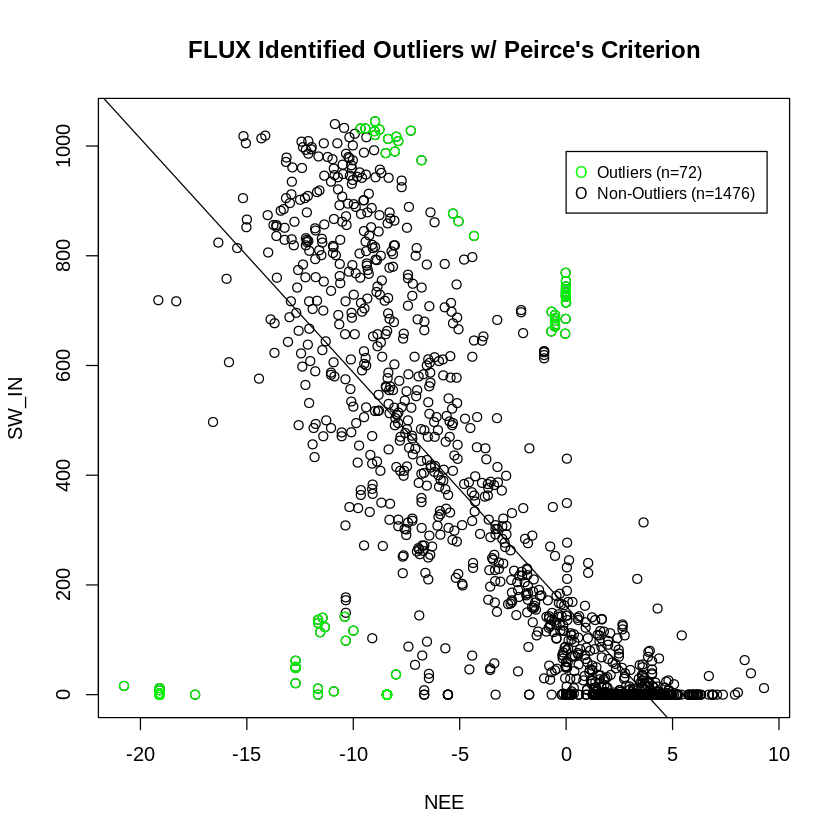

In [ ]:
flux.url <- "https://ds-wm.github.io/course/atsa/data/FLX_US-Goo_FLUXNET2015_SUBSET_HH_2002-05_1-4.csv"
df <- read.csv(flux.url)
lin.mod <- lm(df$SW_IN_F ~ df$NEE_VUT_REF)
res <- lin.mod$residuals


v_outliers <- get_outliers(fitted(lin.mod), df$SW_IN_F, 2, mean(lin.mod$residuals^2))

cat('Total Number of Outliers in the Dataset: ', length(v_outliers))

df$id <- c(1:length(df$SW_IN_F))
outliers <- subset(df, (df$id %in% v_outliers))
no_outliers <- subset(df, !(df$id %in% v_outliers))


plot(df$NEE_VUT_REF, df$SW_IN_F, 
      xlab = 'NEE', 
      ylab='SW_IN', 
      main = "FLUX Identified Outliers w/ Peirce's Criterion")
points(outliers$NEE_VUT_REF, outliers$SW_IN_F, col="green")
abline(lin.mod)
legend(0,990,legend = c('Outliers (n=72)', 'Non-Outliers (n=1476)'), pch = 'OO',col = c('green','black'), ,cex = .8)


The figure above is a scatter plot representing the effect of the Net Ecosystem Exchange (using Variable Ustar Threshold) on the incoming shortwave radiation. Highlighted in green on the plot are the outliers in the dataset, found using Peirce's criterion. Also plotted a linear regression model of the NEE_VUT_REF and SW_IN_F variables. 

From our analysis, we find that there were 72 outliers found in the dataset.

#Conclusion & Discussion
Reflecting on methods and results: 


To create a working script to remove outliers using Peirce's criterion, success was found by combining methodologies from Pierce’s criterion Wikipedia page and the GePiSaT documentation. First, the "peirces_dev" function was taken from the Wikipedia page. This code used Pierce’s criterion to create a threshold for the maximum mean squared error, called Peirce's delta, for the linear regression between NEE_VUT_REF and SW_IN_F. Then, a python script that uses vector comparison to identify data points that exceed the threshold of Pierce’s delta was taken from the GePiSaT documentation. By transforming this python script into R and using it in combination with the "peirces_dev" function, the outliers in the dataset were successfully found and highlighted in the plot.
 
 
One portion of the methodology that had to be changed was the use of a separate function to find mean squared error (MSE). Initially, MSE was calculated using a "goodness of fit" function that returned comma-separated values for MSE, the sum of squared errors, and residual errors. Returning comma-separated values did not work in R, and caused the "get_outliers" code to malfunction. Since the only value needed for the "get_outliers" code is the MSE, the "goodness of fit" function was replaced by calculating the MSE outside of the code for getting outliers and was fed as an input into the "get_outliers" function instead.
 
 
 
The biggest challenge faced was the conversion of the GePiSaT function for "get_outliers" from Python into R. The Python code had some functions, such as "numpy.where" that does not translate into R. This required further research to see what R code could replace this function. For example, the "numpy.where" function was replaced with the R function "which". Once "get_outliers" was successfully transformed from Python to R, subsetting the dataframe for outliers and plotting the data was successful.
 
 
The results were as expected. Peirce's criterion defines outliers as a certain distance from the linear model. For every x, an outlier exists at $\hat{y}$ $\pm$ the distance calculated by Peirce's criterion. When cumulatively plotted, these points begin to form a boundary between outliers and non-outliers. The outliers on the NEE_VUT_REF and SW_IN_F plot exist outside of the boundary calculated by Peirce's criterion.
 
The plot demonstrates a strong negative relationship between NEE_VUT_REF and SW_IN_F. Furthermore, by plotting the outliers, it can be inferred that they exist primarily in the upper and lower range of the shortwave radiation and that they are generally normally distributed.


# References


- Brightwell, Bob, and Bob Dransfeld (n.d.). *Chauvenet's Criterion*, Chauvenet's Criterion for Identifying Outliers. influentialpoints.com/Training/chauvenets_outlier-id-criterion.htm

- Lawrence Berkeley National Laboratory (n.d.). *About the FLUXNET Network*, FLUXNET. https://fluxnet.org/about/

- Ross, Stephen M (2003). *Peirce's criterion for the elimination of suspect experimental data.* Journal of engineering technology 20.2, 38-41.

- Glen, Stephanie. (2017, October 12). *Chauvenet's Criterion*, Statistics How To. www.statisticshowto.com/chauvenets-criterion/

- Glen, Stephanie (n.d.). *Outliers: Finding Them in Data, Formula, Examples. Easy Steps and Video*, Statistics How To. https://www.statisticshowto.com/statistics-basics/find-outliers/

- Peirce's criterion. (2020, December 22). In *Wikipedia*. https://en.wikipedia.org/wiki/Peirce%27s_criterion

- Santoyo, Sergio. “A Brief Overview of Outlier Detection Techniques.” Towards Data Science, Medium, 11 Sept. 2017, towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561. 

- Yang, S., & Berdine, G. (2016). Outliers. *The Southwest Respiratory and Critical Care Chronicles*, *4*(13), 52-56.doi:10.12746/swrccc2016.0413.178.
